# **Chapter 6 Variation: Stochastic Simulation**

## ***Learning Objectives***
* Explain how a system that only involves a small number of molecules can require
a different modeling approach

* Understand the physical basis for the Gillespie algorithm

* Implement stochastic simulations for sets of chemical reactions

* Determine the relationship between ODE-based and stochastic simulation-based
rate parameters

We’re almost finished with our simple circuit, but there’s one thing we haven’t
considered in detail yet: the individual cell. For example, all of the ODE-based
approaches described in Chapters 3-5 depended on assumptions of mass action kinetics.
These assumptions generally hold in a well-mixed system, where the concentrations of
reactants are uniform throughout the system. The population-averaged behavior of a
large culture of individual cells also seems to be well-modeled using such assumptions.

## **Section 6.1. Single cells and low molecule numbers**

But the individual cell is not a well-mixed system, especially at very low numbers − it’s
impossible to “mix” a single molecule so that it is equally distributed throughout a cell!
This fact can lead to interesting biology, as elegantly demonstrated by Sunney Xie’s lab
at Harvard University, where scientists used cutting-edge technology to determine the
protein count and the mRNA count for thousands of genes in thousands of individual E.
coli cells. These data were published in Science in 2010 (see Taniguchi et al. in
Recommended Reading).

The Xie lab’s approach is worth describing because it was very clever. First, they built a
library of E. coli strains in which individual genes had been fused to the yellow
fluorescent protein gene (*yfp*, encoding *YFP*). They then calculated the number of
expressed fluorescent proteins per cell using microscopy and image analysis. To count
the number of mRNAs of the same gene in the same cell, the Xie lab used a technique
called fluorescence *in situ* hybridization, or FISH. In FISH, a number of short
**oligonucleotides** (generally 30-50 nucleotides each) are constructed that are
complementary to the mRNA of interest. Each “oligo” is bound to a fluorescent probe,
so that when a given mRNA is present, the oligos hybridize to it (due to their
complementary sequences) and can be detected with microscopy. One key insight here
was to only develop oligos that hybridized to the *yfp* mRNA instead of to all of the other
genes one by one, which saved a lot of money and time.

With this data set, the Xie lab was positioned to ask a fundamental question that no one
had ever been able to address before: what is the relationship between the number of
mRNAs and the number of proteins in individual cells? Their answer was shocking at the time, and you can see it for yourself in Figure 6.1: *there is no evident relationship
between the two.*

Why is this the case? After all, we already know that transcription and translation are
related through the Central Dogma. This quandary is an interesting case of “causation
without correlation,” and the difference has to do with the stability of the mRNA
molecule. As we discussed in Chapter 2, E. coli’s mRNA degrades very rapidly, with an
average half-life of a few minutes. In contrast, each mRNA is assumed to direct the
production of approximately 10 proteins, each of which remains stable for more than 10 h
on average. This huge difference in the timescales of decay leads to a protein pool that is
much larger than the associated mRNA pool, which you can see from the axes of the plot
at the bottom of Figure 6.1; notice that there are thousands of proteins, while the number
of mRNAs ranges from zero to ten. This small number of mRNA molecules that are in
the cell at any given time adds a strong component of random variability to our
observations, because the same process, working essentially in the same way but in two
different cells, can lead to two very different readouts.

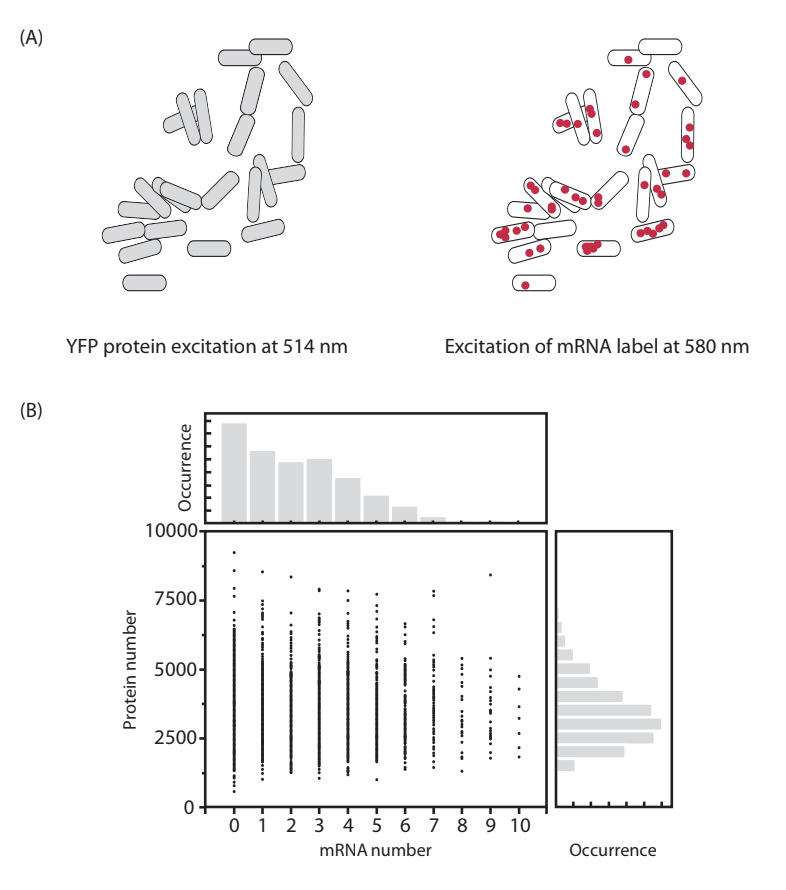


> **Figure 6.1. For many bacterial genes, there is no relationship between protein
number and mRNA number in the same cell at a given time.** Above, the numbers
of protein (left) and mRNA (right) molecules were counted with fluorescent protein
fusions and FISH, respectively. Below, no pattern emerges from the protein and
mRNA counts for the tufA gene; each point is the count for a single cell (more than
5000 cells are represented in this dataset). From Taniguchi, Y., Choi, P. J., Li, G. W.,
Chen, H., Babu, M., Hearn, J., Emili, A., Xie, X. S. Quantifying E. coli proteome and
transcriptome with single-molecule sensitivity in single cells. Science. 2010.
329(5991): 533-538. Reprinted with permission from AAAS.

## **Section 6.2. Stochastic simulations**

How can we model these observations? The modeling approaches that we have studied
so far are **deterministic**, meaning that the same initial conditions input into the same
model will lead to the same dynamic response and outputs. In contrast, in order to
capture the natural variability we see in Figure 6.1, we need a method that is stochastic,
meaning that it accounts for random events.

Stochastic methods differ from ODEs in a number of ways, some of the most important
of which are listed in Figure 6.2. In general, ODEs are the best choice when the system
contains many molecules. Stochastic methods become important when the number of
molecules is very small, because the concept of “concentration” breaks down (because
there’s only one molecule, we need to consider the odds that the molecule will be in the
right place at the right time) and each molecule needs to be counted individually.
Accordingly, the data produced by an ODE-based model are **continuous**, while the data
produced by a stochastic method are **discrete**. In addition, the concept of a reaction
“rate,” which we used for ODEs, must be substituted with the probability that a reaction
occurs over a given time interval (we’ll return to this idea later).

![Figure 6.2](https://drive.google.com/uc?export=view&id=16Dfs47HlFPSfBIF-2LupJYrCa4tPbGC1&)

> **Figure 6.2. A comparison of ODEs and stochastic methods.**

All of the conceptual differences between ODEs and stochastic methods lead to a
substantial change in the way we frame our modeling problem, even for the same system.
One way to frame the general problem of modeling the reactions and interactions of
species (such as proteins, DNA, and RNA) over time as an ODE is:

*Given the concentrations of a number of species $_i$ at a given timepoint $t_0$, as well as the
functions $dx_i/dt$ = f(x,t), determine xi at a later timepoint $t_0 + Δt$.*

Meanwhile, the stochastic problem is represented more like this:

*Given a fixed volume V containing a number $N$ of chemical species $S_i$, which are present with counts $X_i$ at a given timepoint $t_0$, and given that these species can interact through a
number $M$ of chemical reactions $R_j$, simulate $X_i$ at a later timepoint $t_0+Δt$.*

The stochastic formulation contains a slew of variables and symbols, so the best way to
compare these statements directly is with an example (Figure 6.3). Figure 6.3A shows
two reactions, and Figure 6.3B gives the ODEs and initial concentrations that we might
assemble given the reaction system. Here, the number of chemical species N is equal to
3, and the number of chemical reactions, $M$, is equal to 2. The table in Figure 6.3C
contains both the identity of species Si as well as the exact number $X_i$ of each molecule at time $t_0$, and the table in Figure 6.3D represents the two reactions. Note that there are also
constants $c_j$ for each reaction, comparable but not equal to the ODE rate constants $k_j$.
We’ll return to this point later.

![Figure 6](https://drive.google.com/uc?export=view&id=1GXJJuocxUmd4AXxsZ692RXPKXdVyCk-B&)

> **Figure 6.3. Setting up ODEs and a stochastic simulation for a simple reaction
system.** (A) Two reactions convert a single reactant (left) to a single product (right).
(B) A set of ODEs and initial concentrations describing the system. (C) Table of the
species in the system, including the number of molecules of each species at a given
time (I’ve chosen the numbers 5, 10, and 7 simply as an example). (D) Table of the
reaction. The constants c are to be determined (TBD) later in this chapter.

Using this framework, in 1976 Daniel Gillespie developed a stochastic simulation
approach that has been widely useful in many fields, including systems biology. The
core of the idea is to answer two questions about the system at a given timepoint to
determine what happens in the future. The first question is, *when does something happen
next?* The second question naturally follows: *when that moment arrives, what actually
happens?* In other words, given the number of molecules of each species, the volume of
the space, and the available chemical reactions and their associated likelihoods, which molecules react next and when? The answers to these two questions determine the
trajectory of the stochastic simulation.

## **Section 6.3. The probability that two molecules interact and react in a given time interval**

Answering these two questions requires some mathematical gymnastics. Let’s start by
considering something more simple. Let’s assume that we have one molecule each of
two species, $S_1$ and $S_2$, bouncing around in a volume V (Figure 6.4A). Each molecule has
a position within V, and the molecules have radii $r_1$ and $r_2$, respectively. Furthermore, we
consider the two velocities of each by defining a vector, $v_{12}$, which is the relative velocity
of $S_1$ to $S_2$.

We want to determine the probability that these two molecules will interact and react
during a given time interval, δt. To begin, we note that interaction of S1 and S2 can be
defined as occurring when the distance between the centers of each molecule is equal to
the sum of the radii, r1 + r2 (when the molecules are touching; Figure 6.4B). As a result,
we can define a “collision volume” δV$_{coll}$ as a cylinder (Figure 6.4 C):

> <h3> $$
\delta V_{\text{coll}} = \pi r_{12}^2 \overline{v_{12}} \delta t
$$

(Equation 6.1)

If the center of the $S_2$ molecule lies within the $S_1$ molecule's collision volume during the time interval, then the molecules will collide and interact; otherwise, no collision will occur during that time.


![Figure 6](https://drive.google.com/uc?export=view&id=1P5e6fLcgb23bbZxW7zuhtybs5sMmQQ_r&)

> **Figure 6.4. Defining the interaction between two molecules.** (A) One molecule
each of species S1 and S2, with associated radii (r1 and r2, respectively) and the
relative velocity of S1 to S2 (v12). (B) An interaction occurs when the distance
between S1 and S2, r12, is equal to the sum of the individual radii. (C) A collision
volume is defined by the two radii as well as the relative velocity and the time
interval.

Defining a collision volume makes it easy for us to calculate the probability that these
two molecules will interact; we simply want to know how likely the $S_2$ molecule is to lie
within δV$_{coll}$. If we assume that both molecules are equally likely to be in any part of the
total volume, then the probability of an interaction between the $S_1$ and $S_2$ molecules
during the given time interval is simply the ratio of the collision volume to the total
volume:

> <h3> $Prob(S_1-S_2 interaction) = δV_{coll} /V$

*(Equation 6.2)*

Now let’s apply this result more broadly: given a mixture of multiple molecules of $S_1$ and
$S_2$, what is the probability that a molecule of $S_1$ will react with a molecule of $S_2$? Here,
we take advantage of two assumptions. First, we assume that there are not very many
molecules in the system. The assumption sounds reasonable, since this is why we’re
pursuing stochastic simulations in the first place. The second assumption is that the time
step is very short. Taken together, these assumptions imply that for a given δt, the
probability of finding two or more molecules of $S_2$ in any $S_1$ collision volume is
vanishingly small. In other words, the outcome for a given molecule of $S_1$ in a given time
step is binary: either it interacts with a single molecule of $S_2$ or it doesn’t.

So for any given $S_1-S_2$ pair in the mixture, we can use Equation 6.2 to determine the
probability that they will interact. We can then calculate the average probability that any
$S_1-S_2$ pair interacts from the average velocities:

> $$
\left\langle \frac{\delta V_{\text{coll}}}{V} \right\rangle = \frac{\pi r_{12}^2 \left\langle \overline{v_{12}} \right\rangle \delta t}{V}
$$

*(Equation 6.3)*

where the pointed brackets denote averages. If we assume that the distribution of molecular velocities in the system follows a particular distribution (in Gillespie’s case, he assumed that the velocities followed the \textbf{Boltzmann distribution}), then you could substitute an equation for the average based on that distribution, but we don’t need to do that here.

Instead, let’s consider how many of the $S_1-S_2$ pairs in the system that \textit{interact} will also \textit{react}. For example, with the Boltzmann distribution assumption, we would use the following equation:

> $$
\text{Prob(reaction | interaction)} = \exp \left( \frac{-U_u^*}{KT} \right)
$$

*(Equation 6.4)*

where $U_u^*$ is the activation energy for the reaction, $K$ is Boltzmann’s constant, and $T$ is the absolute temperature of the system. The right side of Equation 6.4 will always be in the range of zero to one, because the pairs that react are a subset of the pairs that interact. Substituting Equation 6.3 into 6.4, we obtain:

> $$
\text{Prob(reaction)} = \frac{\pi r_{12}^2 \left\langle \overline{v_{12}} \right\rangle \exp \left( \frac{-U_u^*}{KT} \right) \delta t}{V}
$$

*(Equation 6.5)*

Nearly all of the terms in Equation 6.5 can be lumped together as a single constant c:

> $\text{Prob(reaction)} = c δt$

*(Equation 6.6)*

This constant, c, is the same constant shown in Figure 6.3D and expresses the probability
that a given pair of molecules will react over a given time interval.


## **Section 6.4. The probability of a given molecular reaction occurring over time**

Now that we know the probability of an $S_1-S_2$ pair of molecules reacting in a mixture, we can finally determine the total probability of the $S_1-S_2$ reaction. If we assume that the reaction is characterized by a constant $c_1$, then the probability of an average pair reacting is $c_1 \delta t$. To calculate the overall probability of the reaction, we only need to consider all of the possible pairs. For example, if there are $X_1$ molecules of $S_1$, and $X_2$ molecules of $S_2$, then the total number of possible unique pairs, sometimes denoted by an $h$, is $X_1 X_2$, and the total probability of this reaction occurring is:

> $
\text{TotalProb(reaction}_1) = c_1 X_1 X_2 \delta t = c_1 h_1 \delta t = a_1 \delta t
$

*(Equation 6.7)*

Notice that the subscripts for $c$, $h$, and $a$ all refer to the reaction itself, while the subscripts for the $X$ variables refer to the molecular species. The variable $a$, sometimes referred to as the **reaction propensity**, is defined as the probability that the reaction will occur over a given time interval. The variable $a$ is therefore analogous to the reaction rates that are used for ODEs. Also notice that the form of the activity, $c_1 X_1 X_2$, is similar to the assumption of mass action kinetics in ODEs. In both cases, the rate or activity of the reaction is proportional to the product of the amounts of reactants.


## **Section 6.5. The relationship between kinetic and stochastic constants**

These formulations may lead you to suspect that the c parameters in stochastic
simulations are related to the k parameters in ODEs, and you’d be right – but like most relationships, it’s complicated. In his analysis, Gillespie defined the deterministic kinetic rate constant k as the average reaction rate per unit volume, divided by the product of the average densities of reactants. In the case of many molecules and a well-mixed system, we would simply call the latter the concentrations of S1 and S2. Applying this definition to our simple system gives:

> $ k_1 = \frac{\langle c_1 h_1 / V \rangle}{\langle X_1 \rangle \langle X_2 \rangle / V} = \frac{c_1 \langle X_1 X_2 \rangle / V}{\langle X_1 \rangle \langle X_2 \rangle} \frac{V}{V}$

*(Equation 6.8)*




where the numerator comes from Equation 6.7. Rearranging Equation 6.8, we obtain:

>$ k_1 = \frac{\langle X_1 X_2 \rangle}{\langle X_1 \rangle \langle X_2 \rangle} c_1 V $

*(Equation 6.9)*

Again, in a dense and well-mixed system, $\langle X_1 X_2 \rangle$ is equal to $\langle X_1 \rangle \langle X_2 \rangle$, and so:

> $ k_1 = c_1 V$

*(Equation 6.10)*

In other words, the kinetic rate constant in this case is related to the stochastic simulation
constant by the volume. This should make intuitive sense, because kinetics are based onconcentrations but the simulations described here are based on the numbers of molecules.

I want to emphasize that Equation 6.10 is not general; it applies to this case but certainly
not to others. For example, let’s consider a second reaction, in which two molecules of
S1 react to form S2:

> <h3> $ S_1 + S_1 \xrightarrow{c_2} S_2$

*(Equation 6.11)*


As you can see, this reaction is characterized by its own reaction constant, $( c_2 $). How does $( c_2 $) relate to its corresponding kinetic constant, $( k_2 $)? The major difference lies with how $( h_2 $) is calculated. Remember that $( h $) contains all of the possible reactions between molecules, in this case pairs of $( S_1 $). Since the two reactants are the same species, $( h $) is calculated differently:


> <h3> $ h_2 = \left( \frac{X_1}{2} \right) = \frac{X_1(X_1-1)}{2}$

*(Equation 6.12)*

The corresponding $( k $) for this reaction would therefore be defined as:

> <h3> $
k_1 = \frac{\langle c_2 h_2 / V \rangle}{\langle X_1 \rangle \langle X_1 \rangle / V} = \frac{c_2 \langle X_1 (X_1-1) / 2 \rangle / V}{\langle X_1 \rangle \langle X_1 \rangle} \frac{V}{V} = \frac{1}{2} c_2 \frac{\langle X_1 (X_1-1) \rangle}{X_1} V \approx \frac{1}{2} c_2 V$

*(Equation 6.13)*

As shown, a simple change in the reaction structure leads to a 2-fold change in the
relationship between $k$ and $c$. The changes can also get more complicated; adding more
reactants can lead to multiple powers of $V$ in the equation, for example.

## **Section 6.6. Gillespie’s stochastic simulation algorithm**

Now we are finally ready to address the two questions we posed at the beginning of the
chapter. First, take another look at Equation 6.7, and in particular the reaction activity a.
This quantity is the probability that a given reaction occurs over a given time interval.
Therefore, the reciprocal 1/$a_j$ is the mean time required for the reaction Rj to occur. We
can then define atotal as the propensity for any of the possible reactions in the system to
occur:

> <h3> $ a_{\text{total}} = \sum_{j=1}^{M} a_j $

*(Equation 6.14)*




The reciprocal $( \frac{1}{a_{\text{total}}} $) then becomes the mean time required for any of the reactions to occur.

Therefore, to answer Question 1 – when is the next time that something will happen in our system? – we simply take the following three steps:

1. Let $( \tau $) (tau) be the time interval between the current time and the next reaction.
2. Generate a random number, $( \text{rand}_1 $), between 0 and 1 from a uniform distribution.
3. Determine $( \tau $) from the following equation:

> <h3> $ \tau = \frac{1}{a_{\text{total}}} \ln\left(\frac{1}{\text{rand}_1}\right) $

*(Equation 6.15)*



The logarithmic term in Equation 6.15 is simply the conversion of a random number from a uniform distribution into a random number drawn from an exponential distribution, which favors shorter times over longer times. Multiplying this random number by the mean time gives us the answer to Question 1.

Question 2 – which reaction occurs at the new time? – is also determined from the $( a $)'s and a second random number:

1. Generate a random number, $( \text{rand}_2 $), between 0 and 1 from a uniform distribution.
2. Find the smallest $( q $) such that:

> <h3> $ \sum_{j=1}^{q} a_j > a_{\text{total}} \cdot \text{rand}_2 $

*(Equation 6.16)*


Equation 6.16 requires further explanation, and I’ve drawn Figure 6.5 to help. Think of a
number line that has a length of atotal, and divide the line up into its components aj as we
see in Equation 6.14. Now imagine that this number line is a one-dimensional dartboard.
You throw a dart by multiplying atotal by rand$_2$. The result will fall somewhere on the
atotal number line – in particular, in one of the aj regions. The region that is selected
corresponds to the reaction that occurs.

![Figure 6](https://drive.google.com/uc?export=view&id=1Kng7US1tDipJaqW6jkk77OV1dSmQ64bM&)

> **Figure 6.5. Understanding Equation 6.16.** (A) Depicting atotal as a number line, as well as the left side of Equation 6.16 for all possible values of $q$ given a five-reaction system where $a_j$ is known. (B) Every random number between 0 and 1 corresponds to a specific value of $q$.

The way that we answer these questions, particularly by choosing random numbers,
should reflect the fact that in this chapter we’re performing stochastic simulations, which
are very different from the deterministic approaches that we’ve covered before. No two
stochastic simulations will be exactly alike.

In pseudocode, the algorithm looks something like this:


```
Initialize time t0, molecule numbers Xi
Define cj’s for each reaction
For each time step: %not uniform length!
  Compute aj (c1X1X2)
  atotal = sum(aj)
  Choose two random numbers
  Find tau %Equation 6.15
  Find q %Equation 6.16
  t = t0 + tau
  Update Xi’s
end
end

```


Remember that the time steps are not uniform in length; their length is determined as τ.
Let’s apply this methodology to an example with only two simple reactions:

> <h3> $ A \xrightarrow{c_1} B$
> <h3> $ B \xrightarrow{c_2} D$

First, we initialize the system. In this case, let $t_0 = 0$, $X_A(t_0) = 10$ molecules, $X_B(t_0) = 2$ molecules, and $X_D(t_0) = 0$ molecules. Now assume that the constant associated with the first reaction, $c_1$, will be equal to the second, $c_1 = c_2 = 0.5$.

To work through the next time step, we need to compute $a_1$ and $a_2$. From the reactions, we see that:

> <h3> $a_1 = c_1 X_A = 0.5 * 10 = 5$

> <h3> $a_2 = c_2 X_B = 0.5 * 2 = 1$

We can then calculate $a_{\text{total}} = a_1 + a_2 = 5 + 1 = 6$, for the six sections of our system. Now, the random numbers. Confession: the two numbers that I am about to generate are not “random” by any stretch of the imagination, but they are helpful for the example:

> <h3> $\text{rand}_1 = 1/e$

> <h3> $\text{rand}_2 = 0.4$

Using $\text{rand}_1$ and $a_{\text{total}}$, $\tau$ is calculated from Equation 6.15 as $1/6 * \ln(e) = 1/6 = 0.167$. We can then find $q$ using Equation 6.16, where $a_{\text{total}} * \text{rand}_2 = 2.4$. Thus, the smallest $q$ that exceeds 2.4 is $q = 1$, because $a_q=1 = 5$ (Figure 6.6).


![Figure 6](https://drive.google.com/uc?export=view&id=1_VVot5zhC1fsjqp-K2f3fjxI3EeNw0Ei&)

> **Figure 6.6. Updating Figure 6.5 for our example with only two simple
reactions.**

In other words, the first reaction, A → B , is the one that occurs. This reaction consumes
one A molecule and creates one B molecule. We therefore need to update our $X_A$ and $X_B$
values as follows:

$X_A (t = τ ) = X_A (t_0 )−1 = 9$

$X_B (t = τ ) = X_B (t_0 )+1 = 3$

If the second reaction had been chosen instead, then we would decrement the number of B’s and increment the number of D’s. One time step of the stochastic simulation has been completed.

## **Section 6.7. Stochastic simulation of unregulated gene expression**

Now let’s apply this method to our favorite circuit! We’ll start with the unregulated
system, in which mRNA is produced by transcribing a gene, and this mRNA is translated
to form protein. We can represent these processes as chemical reactions:

$DNA \xrightarrow{c_{trs}} mRNA + DNA$

$mRNA \xrightarrow{c_{trl}} mRNA + Protein$

Note that neither the DNA nor the mRNA is destroyed by the reaction, so they are both
reactants and products. We now add reactions for the loss of mRNA and protein by
decay. In this case, the right side of the reaction is empty to represent the loss of a
molecule:

$mRNA \xrightarrow{c_{mloss}} $

$Protein \xrightarrow{c_{ploss}}$

Now I’m going to take you through actual Python code to simulate the behavior of
this system. Let’s start with the header info and assignment of the c constant values. We assume that $c_{trs}$ has a value of 0.005 mRNAs produced per second, which corresponds to one mRNA produced every few minutes, or 18 molecules produced/hour. For $c_{trl}$, a value of 0.167 proteins/mRNA/s yields ~10 proteins/min/mRNA. Recall that the half-lives of mRNA and protein are quite different, and so we choose half-lives of 2 min for mRNA and 60 min for protein. The cmloss and cploss values are therefore $ln(2)$ mRNAs/120 s and $ln(2)$ proteins/3600 s, respectively.



```
def stochasticSim():
    c_tsc = 0.005
    c_tsl = 0.167
    c_mloss = np.log(2) / 120
    c_ploss = np.log(2) / 3600
```



The next section of code initializes the system and allocates storage for our outputs:

```
# Initial values
    t = 0  # Time
    mRNA = 0
    Protein = 0
    DNA = 1

# Storage
    xx = np.zeros((2, 50000))
    tt = np.zeros(50000)
    a = np.zeros(4)
```

Notice that only the value for DNA is non-zero. This value will remain constant
throughout the simulation because we are simulating a single cell, with only a single copy of our gene of interested. The `tt` array holds all of the time information, the `xx` array holds the values of mRNA and Protein at the times given in `tt`, and the a array holds the value of $a_j$ at every time step.

Let’s start the simulation as a `while` loop. We introduce a counter to tell us when we’ve gone through 50,000 steps. It’s generally not advisable to make the conditional part of the loop depend on clock time, because the steps vary in size and can become very small as the number of molecules increases. Furthermore, I often down-sample the data in practice; I only record one time point for every ten that I generate to reduce the file size of my plots. After starting the `while` loop, we follow the pseudocode that I wrote above
to calculate the propensity values:

```
# Counter
    counter = 1
    while counter <= 50000:
        # Update propensities
        a[0] = c_tsc * DNA  # Transcription
        a[1] = c_tsl * mRNA  # Translation
        a[2] = c_mloss * mRNA  # mRNA loss
        a[3] = c_ploss * Protein  # Protein loss
        a_total = np.sum(a)
```

Calculating the value for τ is fairly straightforward, given what you’ve already read:



```
# Calculate tau
        r1 = np.random.rand()
        tau = (1 / a_total) * np.log(1 / r1)
        t += tau
```



Next, we need to find $q$:



```
# Find q
        r2 = np.random.rand()
        comparison = a_total * r2
        sum_as = 0
        q = 0
        for i in range(4):  # Over all four reactions
            sum_as += a[i]  # Equation 6.16
            if sum_as > comparison:
                q = i + 1
                break
```

Now we need to calculate the new values for mRNA and protein based on which reaction occurred:

```
# Update mRNA and Protein values based on reaction
        if q == 1:  # Transcription
            mRNA += 1
        elif q == 2:  # Translation
            Protein += 1
        elif q == 3:  # mRNA decay
            mRNA -= 1
        elif q == 4:  # Protein decay
            Protein -= 1
```

Finally, we store the values and finish the program:

```
# Store the values
        x = np.array([mRNA, Protein])
        tt[counter - 1] = t
        xx[:, counter - 1] = x
        counter += 1

    return tt, xx
```

All together it looks like this:

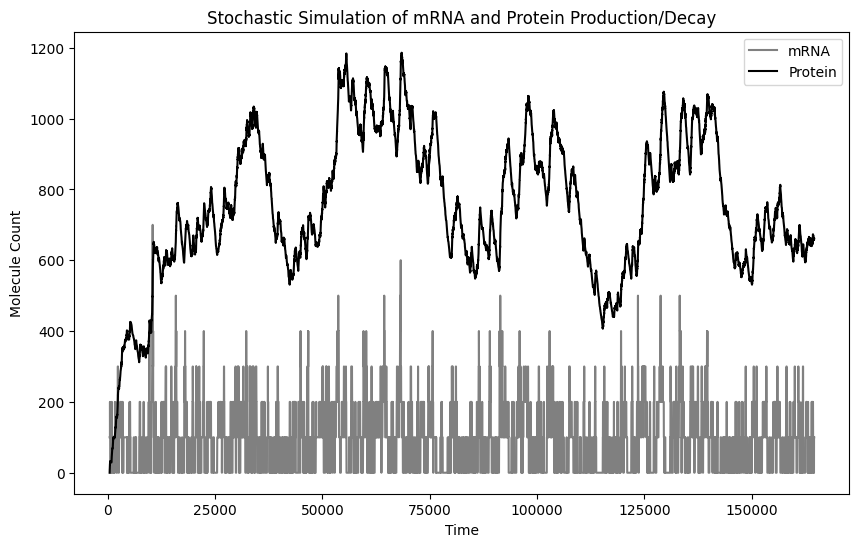

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def stochasticSim():
    c_tsc = 0.005
    c_tsl = 0.167
    c_mloss = np.log(2) / 120
    c_ploss = np.log(2) / 3600

    # Initial values
    t = 0  # Time
    mRNA = 0
    Protein = 0
    DNA = 1

    # Storage
    xx = np.zeros((2, 50000))
    tt = np.zeros(50000)
    a = np.zeros(4)

    # Counter
    counter = 1

    while counter <= 50000:
        # Update propensities
        a[0] = c_tsc * DNA  # Transcription
        a[1] = c_tsl * mRNA  # Translation
        a[2] = c_mloss * mRNA  # mRNA loss
        a[3] = c_ploss * Protein  # Protein loss
        a_total = np.sum(a)

        # Calculate tau
        r1 = np.random.rand()
        tau = (1 / a_total) * np.log(1 / r1)
        t += tau

        # Find q
        r2 = np.random.rand()
        comparison = a_total * r2
        sum_as = 0
        q = 0
        for i in range(4):  # Over all four reactions
            sum_as += a[i]  # Equation 6.16
            if sum_as > comparison:
                q = i + 1
                break

        # Update mRNA and Protein values based on reaction
        if q == 1:  # Transcription
            mRNA += 1
        elif q == 2:  # Translation
            Protein += 1
        elif q == 3:  # mRNA decay
            mRNA -= 1
        elif q == 4:  # Protein decay
            Protein -= 1

        # Store the values
        x = np.array([mRNA, Protein])
        tt[counter - 1] = t
        xx[:, counter - 1] = x
        counter += 1

    return tt, xx

# Run the simulation
tt, xx = stochasticSim()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(tt, xx[0, :] * 100, label='mRNA', color='grey')
plt.plot(tt, xx[1, :], label='Protein', color='black')
plt.xlabel('Time')
plt.ylabel('Molecule Count')
plt.title('Stochastic Simulation of mRNA and Protein Production/Decay')
plt.legend()
plt.show()


![Figure 6](https://drive.google.com/uc?export=view&id=15EoEni0_7AgZVQZYYNEFV9hV6oQSlIBt&)

> **Figure 6.7. mRNA and protein levels for our circuit, calculated using a
stochastic simulation.** (A) mRNA (grey) and protein (black) counts for a single
simulation. Since these simulations are stochastic, this output may vary from
simulation to simulation. (B) Instantaneous mRNA number plotted against the
protein number at the same time point for the entire simulation (50,000 time
points).

An example output is shown in Figure 6.7. As you can see, although the circuit’s
behavior is nothing like what we observed using ODEs (Figure 6.1B), there are some similarities. For example, the steady-state protein level that we would calculate using
ODEs would be:


> <h3> $\left[ \text{Protein} \right]_{ss} = \frac{k_{trl}}{k_{ploss}} \left[ \text{mRNA} \right]_{ss} = \frac{k_{trl}}{k_{ploss}} \frac{k_{trs,max}}{k_{mloss}}$ </h3>

*(Equation 6.17)*

In our case, all of the $k$ parameters are related to the $c$ parameters in the same way because there is only a single reactant. For example, for the reaction DNA → mRNA + DNA:

> <h3> $k_{trs} = \left( \frac{c_{trs} \left[ \text{DNA} \right] V}{\left< \text{DNA} \right> V} \right) = \frac{c_{trs} \left< \text{DNA} \right>}{\left< \text{DNA} \right> V} = c_{trs}$ </h3>

*(Equation 6.18)*

Therefore, we can substitute our $k$'s for $c$'s and vice versa, leading to an expected level of protein at steady state in the ODEs:

> <h3> $\left[ \text{Protein} \right]_{ss} = \frac{0.167 \left[ \text{Protein} \right] \text{s}}{\ln(2) / 120 \text{s}} \frac{0.005 \left[ \text{mRNA} \right] \text{s}}{\ln(2) / 3600 \text{s}} = 750 \text{proteins}$ </h3>

*(Equation 6.19)*

Looking at Figure 6.7, although the cell does not seem to reach a true steady state, the
protein level appears to remain mostly between 600 and 1000 molecules over time.



Let’s return to the dynamics of the mRNA and protein. We’re used to seeing dynamics
that look like exponentials from the ODEs. In contrast, here the mRNA production and
loss dynamics are highly stochastic, and this stochasticity has a major effect on the
production and loss of protein. These protein production dynamics are sometimes called
“burst-like,” because the production of a single mRNA in the system often leads to a
“burst” of subsequent translation and protein production. Look at the earliest part of the
simulation; when mRNA shoots up to 4 molecules/cell, protein production also rises
dramatically, but when the mRNA level goes down to 1 or 0 molecules/cell shortly
thereafter, protein production also halts.

We can also revisit the Xie lab’s observation (Figure 6.1B) that the mRNA and protein
counts in any given cell at an instant in time do not seem to be correlated with one
another. We can create an analogous plot by running the stochastic simulation many
times. If we record the mRNA and protein counts from a randomly chosen time point in
each simulation (Figure 6.7B), our plot looks strikingly similar to the experimental data.

## <u> **Practice Problem 6.1** </u>

**Problem:** *The above example does not include negative feedback. Write the additional chemical reaction(s) to describe the interaction of the protein with the DNA, remembering that the protein-DNA complex does not support transcription. How would you change the pseudocode to reflect this change?*

**Solution:** The inclusion of negative feedback requires two additional reactions, one that leads to association of protein to the DNA to form a complex, and another to reflect dissociation of the complex into free protein and DNA:

$DNA + Protein \xrightarrow{c_{assoc}} Complex$

$Complex \xrightarrow{c_{dissoc}} DNA + Protein$



Only free DNA supports transcription, so there is no need to add another reaction; we already have a transcription reaction involving the free DNA.

To implement these changes into our pseudocode, we first create storage for the DNA and complex by replacing the line for xx:

```
xx = np.zeros((4, 50000))
```

Next, we need to estimate $c_{assoc}$ and $c_{dissoc}$. For our example, let’s use:

```
c_assoc = 0.00001  # bindings/DNA/protein/s
c_dissoc = 0.005   # unbindings/complex/s
```

If there are ~1000 proteins in a cell, and one copy of the DNA binding site, the mean time for complexation to occur is $(1 DNA * 1000 proteins * c_{assoc})^{-1}$ or 100 s. With only one complex in the cell, the mean time for dissociation to occur is $(1 complex * c_{dissoc})^{-1}$ or 200 s, twice as long. These numbers are convenient for us because I want you to visualize the complex from the plots, but in “real life” I would expect the binding and unbinding to occur much faster, probably by 2-3 orders of magnitude.

Note also that $c_{assoc}$ is related to $k_{assoc}$ by a factor of the volume, as you can convince yourselves using the equations I have already given above. To make this conversion, we estimate that the typical E. coli cell is approximately one cubic micron in volume (see Recommended Reading), and so one molecule per cell corresponds to a concentration of roughly 1 nM. As a result, $c_{assoc} = 0.00001$ binding events/DNA molecule/protein molecule/s, while $k_{assoc} = 0.00001 /nM/s$.

We update our propensities $a_j$ with two new statements, and a replacement for $a_{total}$:

```
a_assoc = c_assoc * Protein * DNA
a_dissoc = c_dissoc * Complex
a_total = a_tsc + a_tsl + a_degM + a_degP + a_assoc + a_dissoc
```

Finally, we add the species updates for association and dissociation:

```
elif q == 5:  # complex formation
    Protein -= 1
    DNA -= 1
    Complex += 1
elif q == 6:  # complex dissociation
    Protein += 1
    DNA += 1
    Complex -= 1
```

Making these changes leads the simulation outputs in Figure 6.8. Notice in the upper panel that mRNA is not made when the complex is formed, and as a result, the protein tends to decay.


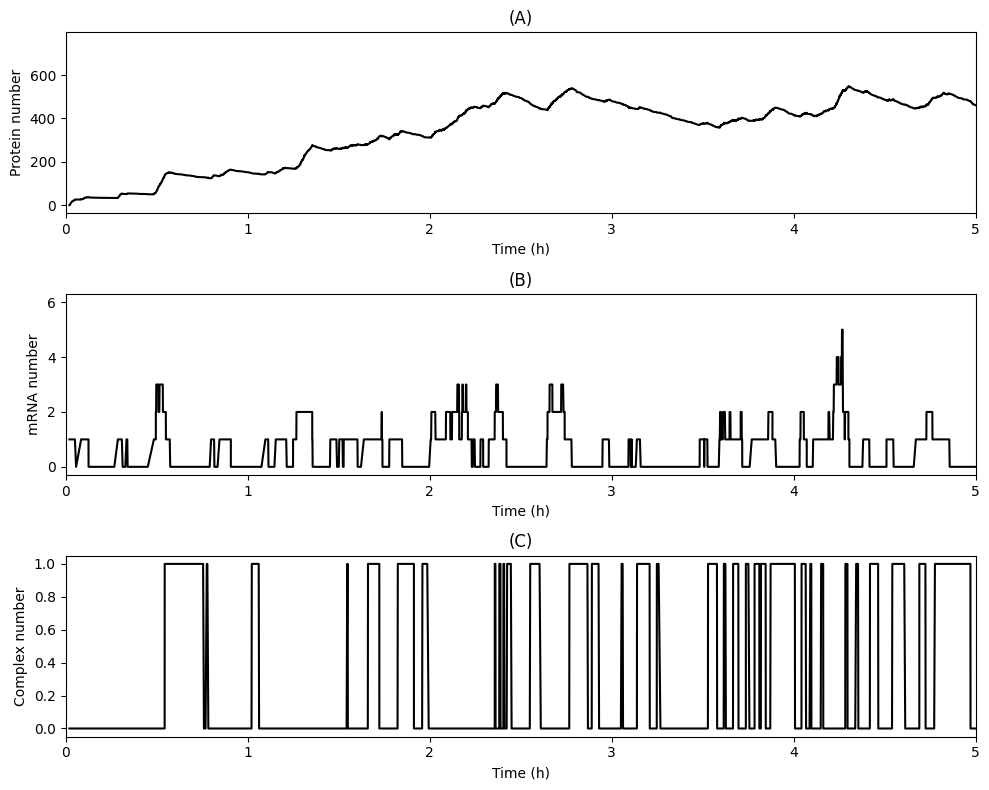

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def stochastic_sim():
    c_tsc = 0.005
    c_tsl = 0.167
    c_mloss = np.log(2) / 120
    c_ploss = np.log(2) / 3600
    c_assoc = 0.00001  # bindings/DNA/protein/s
    c_dissoc = 0.005   # unbindings/complex/s

    # Initial values
    t = 0  # time
    mRNA = 0
    Protein = 0
    DNA = 1
    Complex = 0

    # Storage
    xx = np.zeros((4, 50000))
    tt = np.zeros(50000)
    a = np.zeros(6)

    counter = 1
    while counter <= 50000:
        # Update propensities
        a[0] = c_tsc * DNA        # transcription
        a[1] = c_tsl * mRNA       # translation
        a[2] = c_mloss * mRNA     # mRNA loss
        a[3] = c_ploss * Protein  # protein loss
        a[4] = c_assoc * Protein * DNA  # complex formation
        a[5] = c_dissoc * Complex       # complex dissociation
        a_total = np.sum(a)

        # Calculate tau
        r1 = np.random.rand()
        tau = (1 / a_total) * np.log(1 / r1)
        t += tau

        # Find q
        r2 = np.random.rand()
        comparison = a_total * r2
        sum_as = 0
        q = 0
        for i in range(6):  # over all six reactions
            sum_as += a[i]
            if sum_as > comparison:
                q = i + 1
                break

        # Update species based on which reaction occurred
        if q == 1:  # transcription
            mRNA += 1
        elif q == 2:  # translation
            Protein += 1
        elif q == 3:  # mRNA decay
            mRNA -= 1
        elif q == 4:  # protein decay
            Protein -= 1
        elif q == 5:  # complex formation
            Protein -= 1
            DNA -= 1
            Complex += 1
        elif q == 6:  # complex dissociation
            Protein += 1
            DNA += 1
            Complex -= 1

        # Store the values
        xx[:, counter-1] = [mRNA, Protein, DNA, Complex]
        tt[counter-1] = t
        counter += 1

    return tt, xx

# Run the simulation
tt, xx = stochastic_sim()

# Plot the results
plt.figure(figsize=(10, 8))

# Plot Protein number
plt.subplot(3, 1, 1)
plt.plot(tt / 3600, xx[1, :], 'k-')
plt.xlabel('Time (h)')
plt.ylabel('Protein number')
plt.xlim(0, 5)
plt.title('(A)')

# Plot mRNA number
plt.subplot(3, 1, 2)
plt.plot(tt / 3600, xx[0, :], 'k-')
plt.xlabel('Time (h)')
plt.ylabel('mRNA number')
plt.xlim(0, 5)
plt.title('(B)')

# Plot Complex number
plt.subplot(3, 1, 3)
plt.plot(tt / 3600, xx[3, :], 'k-')
plt.xlabel('Time (h)')
plt.ylabel('Complex number')
plt.xlim(0, 5)
plt.title('(C)')

plt.tight_layout()
plt.show()


> **Figure 6.8. Adding feedback to the stochastic simulation in Practice Problem 6.1.** Shown are the simulation outputs for the amounts of protein (A), mRNA (B), and DNA-protein complex (C) in a single simulation.

Additionally, we can run many simulations (100 in Figure 6.9) to see what happens to the protein and mRNA levels in aggregate, both with and without feedback (Figure 6.9). This figure has been plotted starting at x = 0.5 h for clarity. Notice that just as with the ODEs, the system with feedback has a lower steady-state protein count and a faster response time than the system without feedback.

![Figure 6](https://drive.google.com/uc?export=view&id=1ouIv2cX1_3coLR621oOUSNTxC2-ivjLp&)

> **Figure 6.9. The average (lines) and distribution (shading) protein count for
100 simulations.** The circuit with no feedback appears in darker grey (top line), and the circuit with feedback appears in lighter grey (bottom line). Note that the system with feedback has both a faster response time (left) and a lower steady state (right). The first time point shown is at 0.5 h because the simulations are not fit well with a spline or linear interpolation at earlier time points.

## **Section 6.8. Stochastic simulations versus other modeling approaches**

As you can see, stochastic simulations are an extremely useful representation of our
genetic system in the context of a single cell. These simulations not only helped us to
better understand single-cell measurements, but they also recaptured much of the
information in the ODE-based models. So why don’t we use stochastic simulations all
the time? The more molecules and reactions in the system, the shorter the calculated time
interval τ becomes, and therefore the simulation can quickly become too complex to
compute. We can address this problem by creating hybrid models, in which some parts
of the model are deterministic and use, for example, ODEs, while other parts that involve
a small number of reacting molecules are simulated using a stochastic approach. We’ll
explore such hybrid models in future chapters.

In the meantime, you now have the essential systems biologist’s toolkit – congratulations,
and thanks for sticking it out this far! Let’s apply these methods to some relatively
simple case studies, and then move on to more complicated cellular processes.

## **Chapter Summary**

Until now, all of the methods that we have considered work best for large concentrations
of molecules, such as you would find when growing a large number of cells in a flask.
However, modern technology has enabled us to make measurements within individual
cells, where the number of molecules is much smaller. The behavior of a system with
small numbers of molecules is characterized by random events, chance collisions
between two molecular species that can interact and react with some probability, for
example. These random occurrences are better modeled with stochastic simulations, and
the classical method uses the Gillespie algorithm.

At any given instant in time, the Gillespie algorithm seeks to answer two questions: (1)
when is the next reaction going to occur? and (2) which of the possible reactions actually
occurs at that time? To answer both questions, we first calculate the probability of
occurrence over time for each reaction. Next, we sum the total probability for all
reactions over time, and calculate the mean time required for a reaction to occur as the
reciprocal of the total probability over time. With this mean we can define a distribution
of times (based on an exponential distribution), and by choosing a random number, select
the time at which the reaction occurs. We then choose another random number from a
uniform distribution and use this number to select which reaction occurs, where the
likelihood of a reaction being selected is proportional to its probability over time.

Stochastic simulations can be computationally expensive, especially as the number of
molecules and reactions increases. As a result, their use is typically limited to smaller
systems. Nevertheless, in cases where they can be applied, these simulations can produce
a more realistic estimation of single-cell behavior.

**Recommended Reading**

* BioNumbers, www.bionumbers.hms.harvard.edu. This website is a database of
biological numbers, many of them approximations that are very useful for the types of calculations performed in this book.

* Gillespie, D. T. A general method for numerically simulating the stochastic time evolution of coupled chemical reactions. Journal of Computational Physics. 1976. 22(4): 403-434.

* Gillespie, D. T. Exact stochastic simulation of coupled chemical reactions. Journal of Physical Chemistry. 1977. 81(25): 2340-2361.

* Press, W. H., Teukolsky, S. A., Vetterling, W. T., Flannery, B. P. Numerical Recipes 3rd Edition: The Art of Scientific Computing. Cambridge University Press, 2007.

* From Taniguchi, Y., Choi, P. J., Li, G. W., Chen, H., Babu, M., Hearn, J., Emili, A., Xie, X. S. Quantifying *E. coli* proteome and transcriptome with single-molecule sensitivity in single cells. Science. 2010. 329(5991): 533-538.

## **Problems**

### **Problem 6.1 Probabilities and rate constants**

Earlier in the text, we calculated the probability of the reaction

$ S_1 + S_2 \longrightarrow S_3 $

to be:
$ \text{Total Prob(reaction)} = c_1 X_1 X_2 \delta t $

where \( X_1 \) and \( X_2 \) are the numbers of molecules of \( S_1 \) and \( S_2 \), respectively.

**(a)** What are the probabilities of the following reactions?  
**Reaction 1:** \( S_1 \) is degraded:  
$ S_1 \longrightarrow $

**Reaction 2:** Two molecules of \( S_1 \) and one molecule of \( S_2 \) react to form \( S_3 \):  
$ S_1 + S_1 + S_2 \longrightarrow S_3 $

**Reaction 3:** Three molecules of \( S_1 \) react to form \( S_2 \):  
$ S_1 + S_1 + S_1 \longrightarrow S_2 $


**(b)** For Reaction 3, also derive the relationship between the rate constant \( k \) and the stochastic constant \( c \).

**(c)** How does the Gillespie algorithm account for the possibility of a single molecule participating in two different reactions in the same time interval?


### **Problem 6.2: Enzymatic conversion**

Consider a system in which a molecule X is transported into a cell, and where an enzyme
E is expressed constitutively and can react with a pair of X molecules to form a Y
molecule, as shown:

![Figure 6](https://drive.google.com/uc?export=view&id=1Ty_d6-spsWmOf3e1MXfCqt2wLFP6g7yr&)

The system has six chemical reactions:
1. Import of X into the cell
2. Degradation of X
3. Transcription, which produces an mRNA product
4. Translation, which requires an mRNA and produces an E protein
5. Degradation of E
6. The reaction of two X molecules in the presence of E to form Y

The stochastic rate constants are:

$c_1$ = 2 /(number of molecules of $X_{outside}$ * s)

$c_2$ = 3 /(number of molecules of $X_{inside}$ * s)

$c_3$ = 1 /(number of copies of gene $E$ * s)

$c_4$ = 1 /(number of mRNA molecules * s)

$c_5$ = 1 /(number of molecules of $E$ * s)

$c_6$ = 2/(number of molecules of $E$ * number of molecules of $X^2$ * s)

The initial conditions are:

$X_{outside}$ = 10 molecules

$X_{inside}$ = 5 molecules

$E$ = 4 molecules

gene $E$ = 1 copy

$mRNA$ = 1 molecule

**(a)** Calculate $a_1, a_2, a_3, a_4, a_5, a_6,$ and $a_{total}$.

**(b)** What is the average time required for a reaction to take place?

**(c)** What is the probability that $X$ will be degraded under this set of conditions?

### **Problem 6.3. Positive autoregulatory feedback circuit with cooperativity**

In Problem 4.2, we constructed a set of ODEs for our simple autoregulatory circuit, but with positive instead of negative feedback and with cooperativity. The diagram is shown here:

![Figure 6](https://drive.google.com/uc?export=view&id=19K6iPgPfId4D3gyXf7YoSZrvJF3mzkdQ&)

We will now build a stochastic model of this circuit. The chemical species in our network include mRNA, protein, free DNA, DNA bound to one protein, and DNA bound to two proteins.

There are eight possible chemical reactions for this system:
1. Degradation of mRNA
2. Degradation of protein
3. Translation of mRNA
4. First protein binding to DNA
5. Second protein binding to DNA
6. First protein unbinding from DNA
7. Second protein unbinding from DNA
8. Transcription of DNA bound by two proteins

Let the stochastic reaction constants be:

$
c_{\text{mRNADegradation}} = \frac{\ln(2)}{120} \text{ mRNAs/s}
$

$
c_{\text{ProteinDegradation}} = \frac{\ln(2)}{600} \text{ proteins/s}
$

$
c_{\text{translation}} = 0.167 \text{ proteins/mRNA/s}
$

$
c_{\text{Protein1BindingDNA}} = 9 \text{ associations/DNA/protein/s}
$

$
c_{\text{Protein2BindingDNA}} = 25 \text{ associations/DNA/protein/s}
$

$
c_{\text{Protein1UnbindingDNA}} = 15 \text{ dissociations/complex/s}
$

$
c_{\text{Protein2UnbindingDNA}} = 15 \text{ dissociations/complex/s}
$

$
c_{\text{transcription}} = 0.5 \text{ mRNA/s}
$


Furthermore, the initial conditions of the system are:

mRNA = 0 molecules

Protein = 10 molecules

Free DNA = 1 molecule

DNA bound to one protein = 0 molecules

DNA bound to two proteins = 0 molecules

**(a)** Use MATLAB to write a Gillespie algorithm to understand the time dynamics of
the above system. Run your algorithm for 500,000 steps. Plot the amounts of
mRNA and free protein, as well as the number of proteins bound to the DNA,
over time. You may consider plotting these on separate graphs if their scales are
very different. For the sake of readability, you may also choose to plot fewer steps
(for example, every 10th step). Describe your results in your own words.




**(b)** Now run the algorithm five more times. How do the simulations differ from one another? Where does the difference come from?



**(c)** Now change the parameters to make the processes and interactions in the system occur less frequently, as we would often see in individual bacterial cells. Use your Gillespie code from (a), except with these new parameter values:

$
c_{\text{Protein1BindingDNA}} = 0.001 \text{ associations/DNA/protein/s}
$

$
c_{\text{Protein2BindingDNA}} = 0.1 \text{ associations/DNA/protein/s}
$

$
c_{\text{Protein1UnbindingDNA}} = 0.005 \text{ dissociations/complex/s}
$

$
c_{\text{Protein2UnbindingDNA}} = 0.005 \text{ dissociations/complex/s}
$

$
c_{\text{transcription}} = 0.005 \text{ mRNA/s}
$

$
c_{\text{translation}} = 0.167 \text{ proteins/mRNA/s}
$

$
c_{\text{mRNADegradation}} = \frac{\ln(2)}{120} \text{ mRNAs/s}
$

$
c_{\text{ProteinDegradation}} = \frac{\ln(2)}{600} \text{ proteins/s}
$

In this case, only run your algorithm for 1000 steps, and plot the amounts of mRNA and free protein over time. Again, you may want to run your code a few times to note the trends in outcomes. Comment on any interesting patterns that you see in your graphs of mRNA and free protein. Describe any relationships that you see between the mRNA and protein quantities.

### **Problem 6.4: Stochastic modeling of the mf-Lon network using the Gillespie algorithm**

Let’s return to the *mf*-Lon network that we considered in Problems 4.3 and 5.4, in which
the expression of phage lambda protein positively regulates its own expression, but can
be degraded by the expression of the Lon protease. For this problem, we will consider
the system with a small number of molecules. As before, we will assume cooperative
binding (H = 2). We will also assume that the state in which the promoter is bound by
one cI molecule is a very short-lived intermediate, and therefore each DNA binding
reaction can be modeled as:

2(cIprotein) + (free$P_{RM}$ ) → $P_{RM}$ ( bound to2cIproteins)

![Figure 6](https://drive.google.com/uc?export=view&id=13-lVUhpF4SPQqcILx7qERwjAr--s42Gs&)

In order to define our stochastic model, we need to explicitly define all possible chemical
reactions for each of the chemical species. The chemical species in our network include
*mf*-Lon mRNA, *mf*-Lon protein, cI mRNA, cI protein, free $P_{RM}$, and $P_{RM}$ bound to two cI
proteins. Transcription is possible only when there are two cI proteins bound to the
promoter.

There are 12 reactions in our system:
1. Transcription of *mf*-Lon mRNA
2. Degradation of *mf*-Lon mRNA
3. Translation of *mf*-Lon protein
4. Degradation of *mf*-Lon protein
5. Binding of two cI proteins to $P_{RM}$
6. Unbinding of two cI proteins from $P_{RM}$
7. Transcription of cI mRNA
8. Degradation of cI mRNA
9. “Leaky” expression of cI mRNA (not dependent on active $P_{RM}$)
10. Translation of cI protein
11. Degradation of cI protein
12. Enzymatic degradation of cI protein by *mf*-Lon

Let the stochastic rate constants be:

$
c_{\text{mf-LonTranscription}} = 0.001 \text{ mRNAs/s}
$

$
c_{\text{mf-LonRNADegradation}} = c_{\text{cImRNADegradation}} = 2.38 \times 10^{-3} \text{ mRNAs/s}
$

$
c_{\text{mf-LonTranslation}} = c_{\text{cITranslation}} = 5 \times 10^{-5} \text{ proteins/mRNA/s}
$

$
c_{\text{mf-LonDegradation}} = c_{\text{cIDegradation}} = 10^{-4} \text{ proteins/s}
$

$
c_{\text{2cI1BindPRM}} = 0.05 \text{ associations/DNA/protein}^2/\text{s}
$

$
c_{\text{2cI1UnbindPRM}} = 1.25 \times 10^{-9} \text{ dissociations/complex/s}
$

$
c_{\text{cImRNATranscription}} = 1.35 \times 10^{-9} \text{ mRNAs/s}
$

$
c_{\text{cILeakage}} = 0.1 \text{ mRNAs/s}
$

$
c_{\text{cIDegradationBymf-Lon}} = 0.071 /\text{copies of cI/copies of mf-Lon/s}
$

Let the initial conditions of the system be:

Molecules of *mf*-Lon mRNA = 0

Molecules of *mf*-Lon protein = 0

Free $P_{RM}$ = 1

$P_{RM}$ bound to two cI proteins = 0

Molecules of cI mRNA = 0

Molecules of cI protein = 0

**(a)** Use MATLAB to write a Gillespie algorithm to understand the time dynamics of the above system. Run your algorithm for 50,000 steps. Plot the numbers of molecules of mRNA and protein for both *mf*-Lon and cI over time. Provide a brief description of the time dynamics. As your algorithm is stochastic, you may want to run your code a few more times to note the trends in outcomes.

**(b)** Now perform an “experiment”! You can make the *mf*-Lon protein much more
stable by changing the *mf*-Lon protein degradation parameter by 100-fold. What
happens to the dynamic behavior of the system following this change? Provide
plots of the resulting dynamics for three simulations.

**(c)** Referring back to Problems 4.3 and 5.4, comment on how the behavior you
observed in your stochastic simulations versus your ODE-based analyses could
inform the method you use for your modeling. Similarly, explain how the correct
choice of a modeling algorithm impacts the prediction of the behavior of a
biological system.